In [11]:
from dotenv import load_dotenv
load_dotenv()

True

In [10]:
# !pip install -U langgraph langsmith langchain_anthropic 
!pip install -qU langchain-openai
!pip install openai

In [8]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [17]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

def searchFAQ(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

def searchVectorDB(state: State):
    return {"messages": [llm.invoke(state["messages"])]}
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("searchFAQ", searchFAQ)
graph_builder.add_node("searchVectorDB", searchVectorDB)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [19]:
graph_builder.add_edge(START, "searchFAQ")
graph_builder.add_edge("searchFAQ", "searchVectorDB")
graph_builder.add_edge("searchVectorDB", END)
graph = graph_builder.compile()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


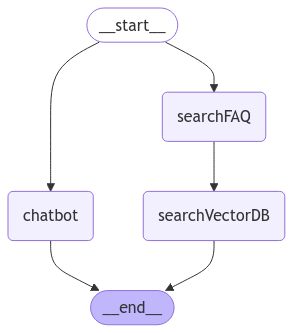

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
graph.invoke({'messages': ''})